## **Model 5 : Medium CNN + Model 2 preprocessing**

**Preprocessing**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_dir = "datasets/Training"
test_dir  = "datasets/Testing"

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Validation split
val_size = int(0.2 * len(train_ds))
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

# Normalize
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x,y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x,y: (normalization_layer(x), y))

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


**Build Medium CNN**
> Architecture
- Conv2D(32) → ReLU → MaxPool
- Conv2D(64) → ReLU → MaxPool
- Conv2D(128) → ReLU → MaxPool
- Flatten → Dense(128, ReLU) → Dense(4, softmax)

In [5]:
def build_medium_cnn(input_shape=(128,128,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model5 = build_medium_cnn()
model5.summary()

d:\Python11\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

**Callbacks**

In [6]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='models/model05_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

**Compile**

In [7]:
model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

**Train**

In [8]:
history5 = model5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # EarlyStopping will halt earlier
    callbacks=callbacks
)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6305 - loss: 0.8707
Epoch 1: val_loss improved from None to 0.39660, saving model to models/model05_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 31s 200ms/step - accuracy: 0.7334 - loss: 0.6713 - val_accuracy: 0.8607 - val_loss: 0.3966 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8545 - loss: 0.3915
Epoch 2: val_loss improved from 0.39660 to 0.33852, saving model to models/model05_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - accuracy: 0.8676 - loss: 0.3588 - val_accuracy: 0.8821 - val_loss: 0.3385 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9138 - loss: 0.2593
Epoch 3: val_loss improved from 0.33852 to 0.29968, saving model to models/model05_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - accuracy: 0.9225 - loss: 0.2288 - val_accuracy: 0.8982 - val_loss: 0.2997 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9456 - loss: 0.1612
Epoch 4: val_loss improved from 0.29968 to 0.18689, saving model to models/model05_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.9517 - loss: 0.1438 - val_accuracy: 0.9330 - val_loss: 0.1869 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9695 - loss: 0.0882
Epoch 5: val_loss did not improve from 0.18689
144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - accuracy: 0.9739 - loss: 0.0765 - val_accuracy: 0.9339 - val_loss: 0.2342 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9721 - loss: 0.0758
Epoch 6: val_loss did not improve from 0.18689
144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - accuracy: 0.9774 - loss: 0.0647 - val_accuracy: 0.9438 - val_loss: 0.2031 - learning_rate: 0.0010
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9814 - loss: 0.0528
Epoch 7: val_loss did not improve from 0.18689

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - accuracy: 0.9848 - loss: 0.0500 - val_ac

**Load best model**

In [9]:
best_model5 = tf.keras.models.load_model('models/model05_best.h5')

**Evaluate**

In [10]:
# Evaluate on test set
test_loss, test_acc = model5.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get final training & validation metrics
final_train_acc = history5.history['accuracy'][-1]
final_train_loss = history5.history['loss'][-1]
final_val_acc   = history5.history['val_accuracy'][-1]
final_val_loss  = history5.history['val_loss'][-1]

print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9169 - loss: 0.2430
Test accuracy: 0.9169
Test loss: 0.2430
Final training accuracy: 0.9996
Final training loss: 0.0032
Final validation accuracy: 0.9589
Final validation loss: 0.2135


**Loss curve plotting**

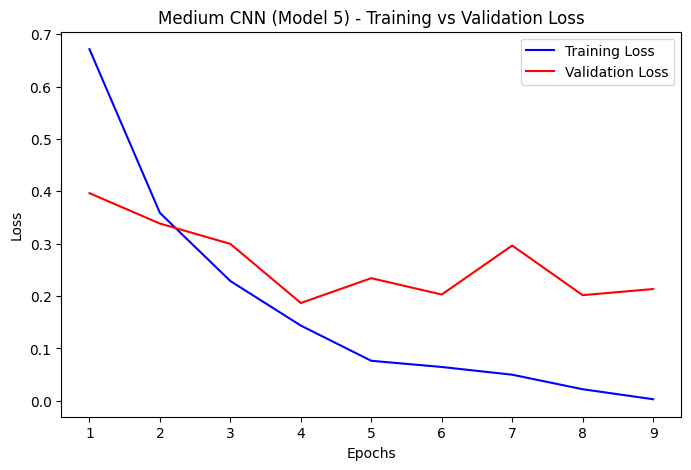

In [11]:
import matplotlib.pyplot as plt

def plot_loss_curves(history, model_name="Model"):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call for Model 5
plot_loss_curves(history5, model_name="Medium CNN (Model 5)")

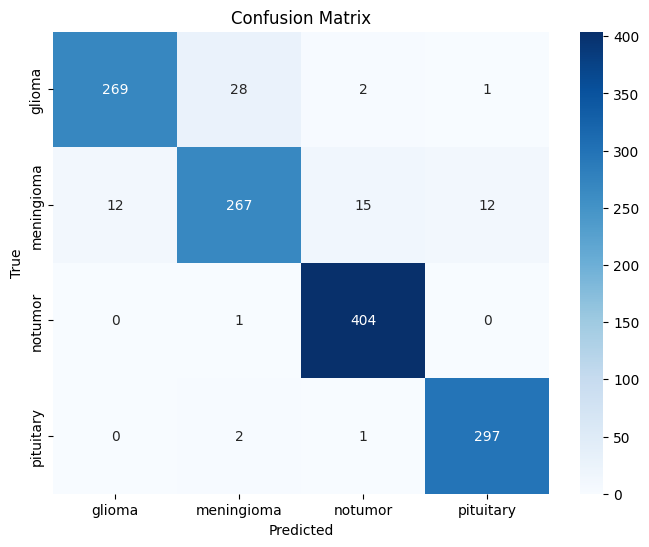


Classification Report:

              precision    recall  f1-score   support

      glioma       0.96      0.90      0.93       300
  meningioma       0.90      0.87      0.88       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



In [2]:
from plot_utils import plot_confusion_matrix_from_dataset

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix from saved model
plot_confusion_matrix_from_dataset("models/model05_best.h5", test_ds, class_names)
